In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from json import loads

import stim

In [27]:
def filter_generator(json_metadata, circuit_type='unitary'):
    return loads(json_metadata)['style'] == 'unitary'
def get_d(json_metadata):
    return loads(json_metadata)['d']
def get_d2(json_metadata):
    return loads(json_metadata).get('d2')

def get_d1(json_metadata):
    return loads(json_metadata).get('d1')


In [28]:
df = pd.read_csv("./emulated-enumeration-stats.csv")
df = df[df.json_metadata.apply(filter_generator)]
for key in df.keys():
    if key.strip() in ['shots', 'errors', 'discards']:
        df[key.strip()] = df[key].astype(float)
        del df[key]
df['PL'] = df.errors / (df.shots - df.discards)
df['rate'] = (1 - df.discards / df.shots) ** (-1)
df['d'] = df.json_metadata.apply(get_d)
df['d2'] = df.json_metadata.apply(get_d2)
df['min_PL'] = df.errors / (df.shots - df.discards) 
df3 = df[df.d == 3]
df5 = df[df.d == 5]

ps = np.array([2e-3, 1e-3, 5e-4, 3e-4, 2e-4, 1e-4])
p_labels = ['2e-3', '1e-3', '5e-4', '3e-4', '2e-4', '1e-4'] 


In [29]:
df = pd.read_csv("combined_stats.csv")
df.columns = [col.strip() for col in df.columns]

df['circuit'] = df.json_metadata.apply(lambda x:loads(x)['c'])
df['d1'] = df.json_metadata.apply(get_d1)
df['d2'] = df.json_metadata.apply(get_d2)
df['p'] = df.json_metadata.apply(lambda x:loads(x)['p'])
df['num_ghz_measurements'] = df.json_metadata.apply(lambda x:loads(x).get('num_ghz_measurements'))
df['noise'] = df.json_metadata.apply(lambda x:loads(x).get('noise'))
df['accept'] = df.shots - df.discards

df['rate'] = df.accept/df.shots
df['error_rate'] = df.errors/ (df.shots - df.discards)
df['y_err'] = (df.errors**0.5 / (df.shots - df.discards))
df['min_PL'] = df.errors/ df.accept + 3 / df.accept

df['max_radius'] = df.json_metadata.apply(lambda x:loads(x).get('max_radius'))
df['post_selected_rounds'] = df.json_metadata.apply(lambda x:loads(x).get('post_selected_rounds'))

df = df[df['noise'] == 'uniform']

In [30]:
def anlayze_counter(counter, cutoff):
    shots = 0
    errors = 0
    for key, value in counter.items():
        gap = int(key[1:])
        if gap >= cutoff:
            shots += value
            if key[0] == 'E':
                errors += value
    return shots, errors

def get_step_from_line(line, step):
    accpeted_shots, error = anlayze_counter(loads(line.custom_counts), step)
    discards = line.shots - accpeted_shots
    if accpeted_shots == 0:
        return 0,0,0
    # if error == 0:
    #     return line.shots/accpeted_shots, 1/accpeted_shots
    return line.shots/accpeted_shots, error/accpeted_shots, (error**0.5/accpeted_shots)

name_dictionary = {("end2end") : "This Work [Surface code]",
                   "end2end-inplace-distillation" : "2024 Gidney et al"}
def get_name(line):
    json_metadata = loads(line.json_metadata)
    return f"{name_dictionary[json_metadata['c']]}, $d_1 = {json_metadata['d1']}$, $d_2 = {json_metadata['d2']}$"

gap_samples = df[(df.decoder =='GapSampler') & (df.max_radius.isna()) & (df.p == 0.001)]
df_gidney2024 = pd.read_csv("./2024-gidney-stats.csv")
df_gidney2024.columns = [i.strip() for i in df_gidney2024.columns]
df_gidney2024['p'] = df_gidney2024.json_metadata.apply(lambda x:loads(x)['p'])
df_gidney2024 = df_gidney2024[(df_gidney2024.decoder == 'desaturation') & (df_gidney2024.p == 0.001)]

In [31]:
df.circuit.unique()

array(['end2end', 'init', 'init-color-code', 'init-color-code-corrected'],
      dtype=object)

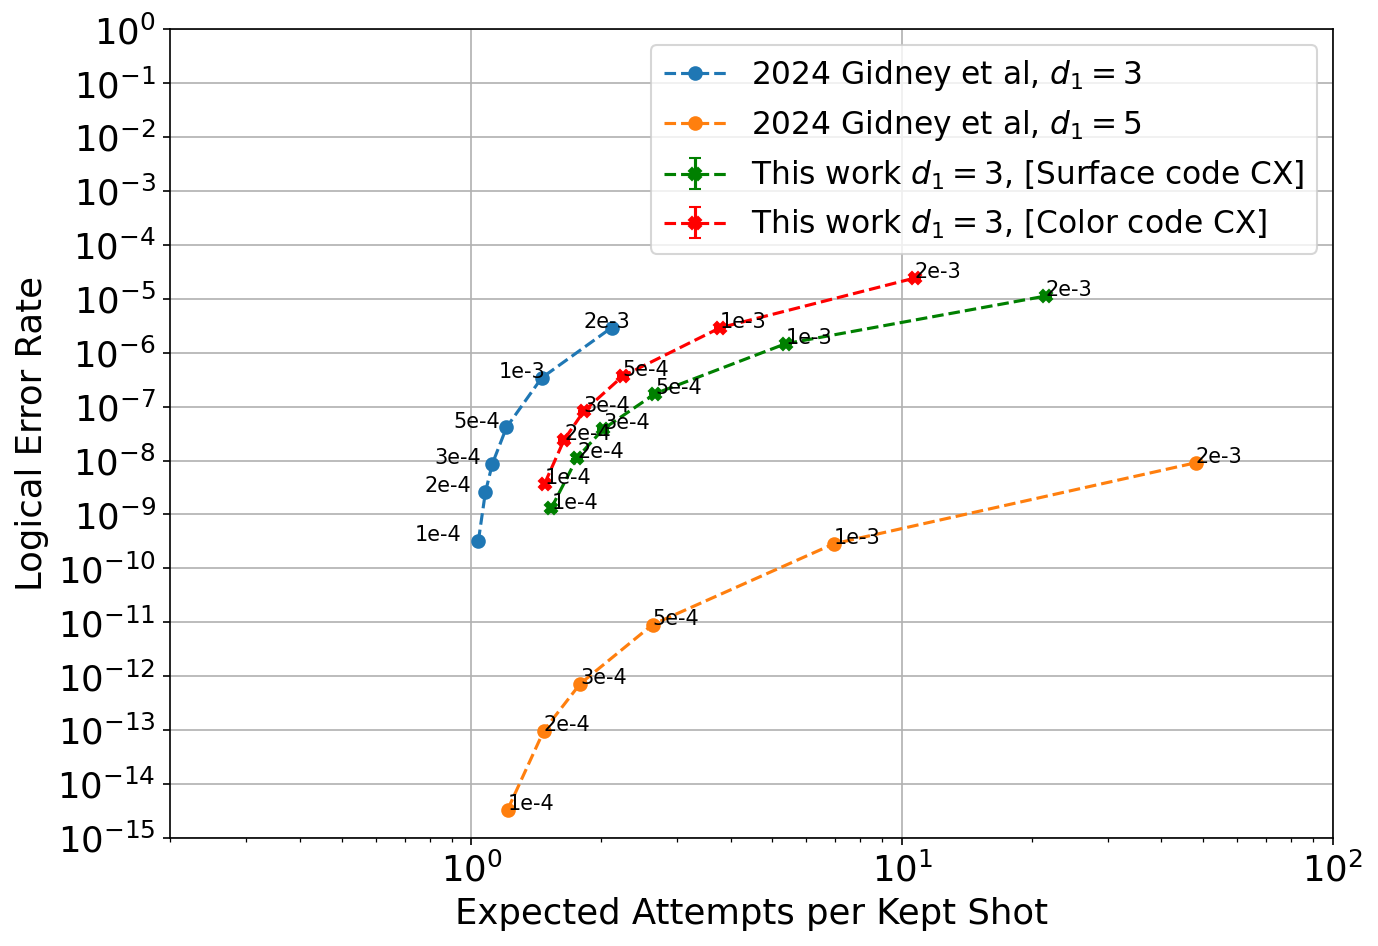

In [35]:
plt.figure(figsize=(10,7), dpi = 150)
 
plt.plot(df3.rate, df3.PL, '--o', label='2024 Gidney et al, $d_1=3$')
for p, p_label, rate, fid in zip(ps, p_labels[::-1], df3.rate, df3.PL):
    plt.text(rate-0.3, fid, p_label, fontsize = 10)
# 
plt.plot(df5.rate, df5.PL, '--o', label='2024 Gidney et al, $d_1=5$')
for p, p_label, rate, fid in zip(ps, p_labels[::-1], df5.rate, df5.PL):
    plt.text(rate, fid, p_label, fontsize = 10)
    
circuit_names = {"init" : "Surface code CX",
                 "init-gidney" : "Double GHz Measurements",
                 '4q-init' : '4 Qubit code',
                 '4q-init-ghz-type' : '4 Qubit code',
                 'init-color-code-corrected' : 'Color code CX',
                 }
circuit_color = {"init" : "green",
                "init-color-code-corrected" : "red"}
for circuit in circuit_names.keys():
    for d1, dgroup  in df[ (df.circuit == circuit)].groupby('d1'):
        for ghz_meas, group in dgroup.groupby('num_ghz_measurements'):
            if [d1, ghz_meas, circuit] in  [
                [3, 3, 'init'],
                [3, 3, 'init-gidney'],
                [3, 3, 'init-color-code-corrected'],
                # [3, 2, 'init-color-code'],
                # [2, 2, '4q-init'],
                # [2, 2, '4q-init-ghz-type']
            ]:
                x = 1/group.rate
                y = group.error_rate 
                y_err = group.y_err
                
#                 plt.plot(x, y ,'--X', label=f'This work $d_1={int(d1)}$, [{circuit_names[circuit]}]')
                plt.errorbar(x, y ,fmt='--X',yerr=y_err,capsize = 3, 
                             label=f'This work $d_1={int(d1)}$, [{circuit_names[circuit]}]',
                            color = circuit_color[circuit])
                for p, p_label, rate, fid in zip(ps, p_labels[::-1], x, y):
                    if fid != 0: 
                        plt.text(rate, fid, p_label, fontsize = 10)

     

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-15, 1)
plt.xlim(0.2e0, 1e2)
plt.yticks(np.logspace(-15, 0, 16), fontsize = 17)
plt.xticks(fontsize = 17)
plt.legend(fontsize = 15)
plt.ylabel("Logical Error Rate", fontsize = 17)
plt.xlabel("Expected Attempts per Kept Shot", fontsize=17)
# plt.title("Initialization", fontsize = 17)
plt.grid()
plt.savefig("figures/cultivation.png")

(1e-10, 0.01)

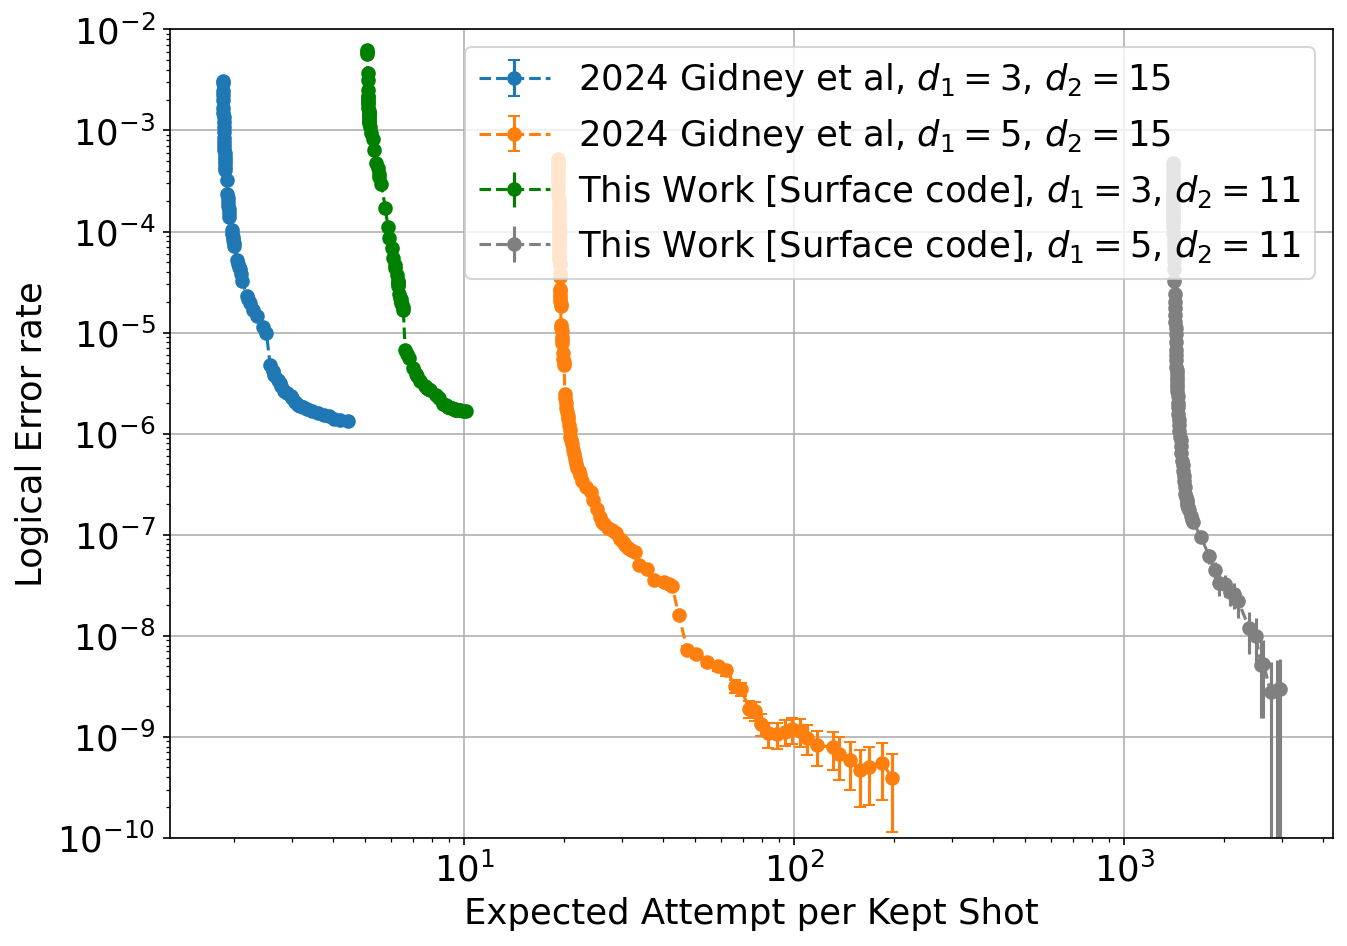

In [38]:
plt.figure(figsize=(10,7), dpi = 150)
steps = range(0, 120,    1)
for line in list(df_gidney2024.iloc):
    xs, ys, yerr  = zip(*[get_step_from_line(line, step) for step in steps] )
    xs, ys, yerr = np.array(xs), np.array(ys), np.array(yerr)
    plt.errorbar(xs[ys>0], ys[ys>0],yerr=yerr[ys>0],capsize = 3,fmt= '--o', label = get_name(line))
    
for line,color in zip(list(gap_samples.iloc), ['green', 'gray']):
    if line.d2 in [11] and line.d1 == line.num_ghz_measurements:
        xs, ys, yerr  = zip(*[get_step_from_line(line, step) for step in steps] )
        xs, ys, yerr = np.array(xs), np.array(ys), np.array(yerr)
        plt.errorbar(xs[ys>0], ys[ys>0],yerr=yerr[ys>0],fmt= '--o', label = get_name(line), color= color)

        

plt.yscale('log')
plt.xscale('log') 
plt.legend(fontsize = 17, loc = 'upper right')
plt.grid()
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.ylabel("Logical Error rate", fontsize = 17)
plt.xlabel("Expected Attempt per Kept Shot", fontsize=17)
# plt.title("Initialization and expansion (p=0.001)", fontsize = 17)
plt.savefig("figures/cultivation_and_expansion.png")
plt.ylim(1e-10, 1e-2)

In [9]:
df = pd.read_csv("combined_stats.csv")
df.columns = [col.strip() for col in df.columns]

df['circuit'] = df.json_metadata.apply(lambda x:loads(x)['c'])
df['d1'] = df.json_metadata.apply(get_d1)
df['d2'] = df.json_metadata.apply(get_d2)
df['p'] = df.json_metadata.apply(lambda x:loads(x)['p'])
df['num_ghz_measurements'] = df.json_metadata.apply(lambda x:loads(x).get('num_ghz_measurements'))
df['noise'] = df.json_metadata.apply(lambda x:loads(x).get('noise'))
df['accept'] = df.shots - df.discards

df['rate'] = df.accept/df.shots
df['error_rate'] = df.errors/ (df.shots - df.discards)
df['min_PL'] = df.errors/ df.accept + 3 / df.accept
df['y_err'] = (df.errors**0.5 / (df.shots - df.discards))

df['max_radius'] = df.json_metadata.apply(lambda x:loads(x).get('max_radius'))
df['post_selected_rounds'] = df.json_metadata.apply(lambda x:loads(x).get('post_selected_rounds'))


# df = df[df['noise'] == 'uniform_atoms']

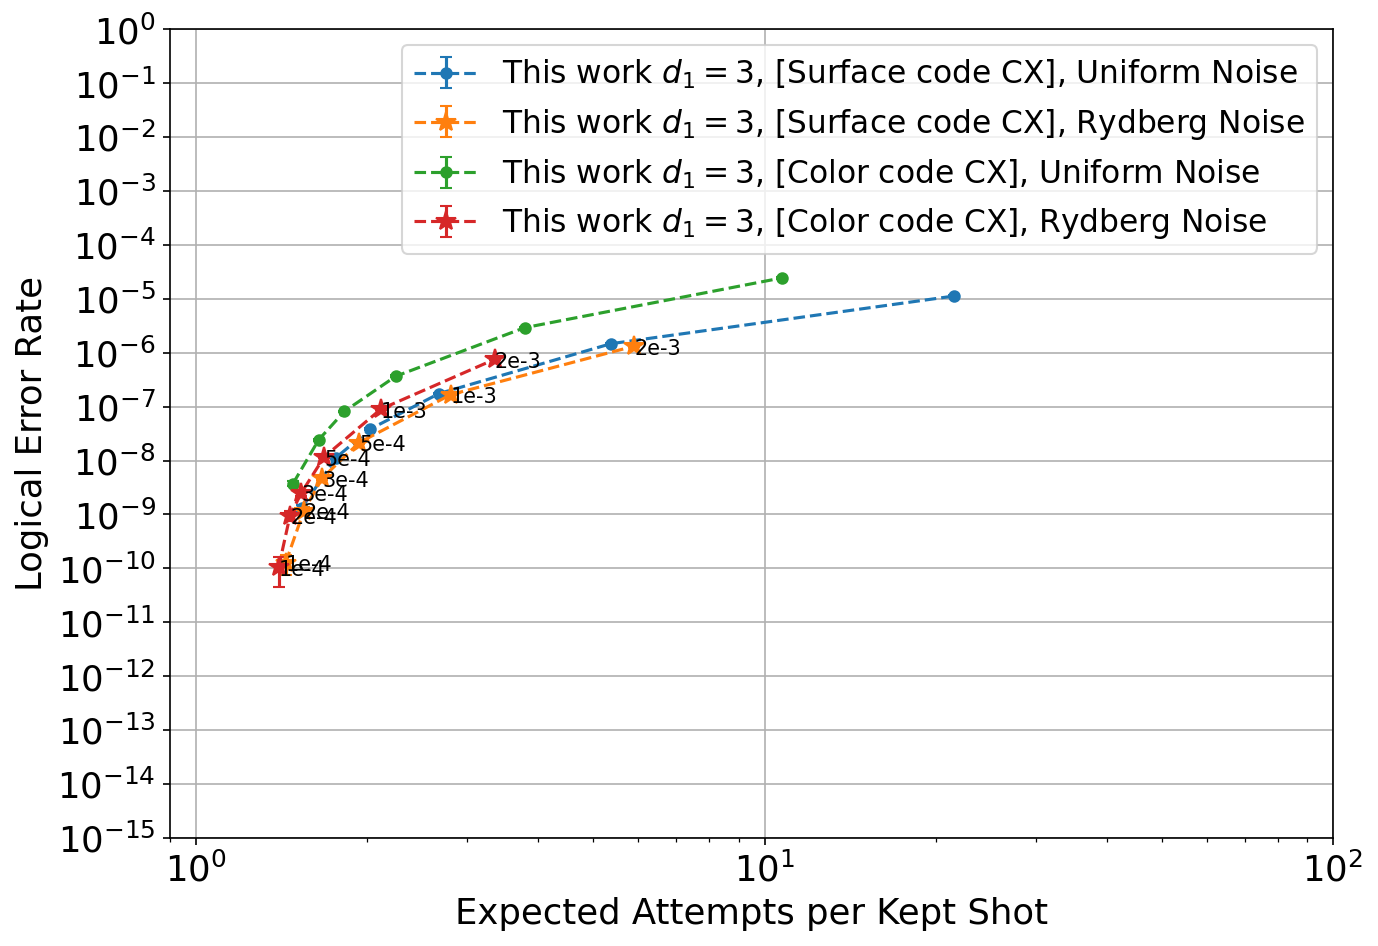

In [10]:
plt.figure(figsize=(10,7), dpi = 150)
 
circuit_names = {"init" : "Surface code CX",
                 "init-gidney" : "Double GHz Measurements",
                 '4q-init' : '4 Qubit code',
                 '4q-init-ghz-type' : '4 Qubit code',
                 'init-color-code-corrected' : 'Color code CX',
                 }
circuit_color = {"init" : "red",
                "init-color-code-corrected" : "blue"}
noise_names = {"uniform" : "Uniform Noise",
            "uniform_atoms" : "Rydberg Noise"}
for circuit in circuit_names.keys():
    for d1, dgroup  in df[ (df.circuit == circuit)].groupby('d1'):
        for ghz_meas, group_ in dgroup.groupby('num_ghz_measurements'):
            for noise, group in group_.groupby("noise"):
                if [d1, ghz_meas, circuit] in  [
                    [3, 3, 'init'],
#                     [3, 3, 'init-gidney'],
                    [3, 3, 'init-color-code-corrected'],
                    # [3, 2, 'init-color-code'],
                    # [2, 2, '4q-init'],
                    # [2, 2, '4q-init-ghz-type']
                ]:
                    
                    x = 1/group.rate
                    y = group.error_rate 
                    y_err = group.y_err

                    label_shift = 1.3 if noise == 'uniform' else 0.7
                    tick = '--.' if noise == 'uniform' else '--*'
                    plt.errorbar(x, y ,fmt = tick,yerr = y_err , capsize = 3,
                                 label=f'This work $d_1={int(d1)}$, [{circuit_names[circuit]}], {noise_names[noise]}',markersize = 10)

                    for p, p_label, rate, fid in zip(ps, p_labels[::-1], x, y):
                        if fid != 0  and ( noise != 'uniform'): 
                            plt.text(rate, fid*label_shift, p_label, fontsize = 10)

     

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-15, 1)
plt.xlim(0.9e0, 1e2)
plt.yticks(np.logspace(-15, 0, 16), fontsize = 17)
plt.xticks(fontsize = 17)
plt.legend(fontsize = 15)
plt.ylabel("Logical Error Rate", fontsize = 17)
plt.xlabel("Expected Attempts per Kept Shot", fontsize=17)
# plt.title("Initialization", fontsize = 17)
plt.grid()
plt.savefig("figures/cultivation_atoms.png")

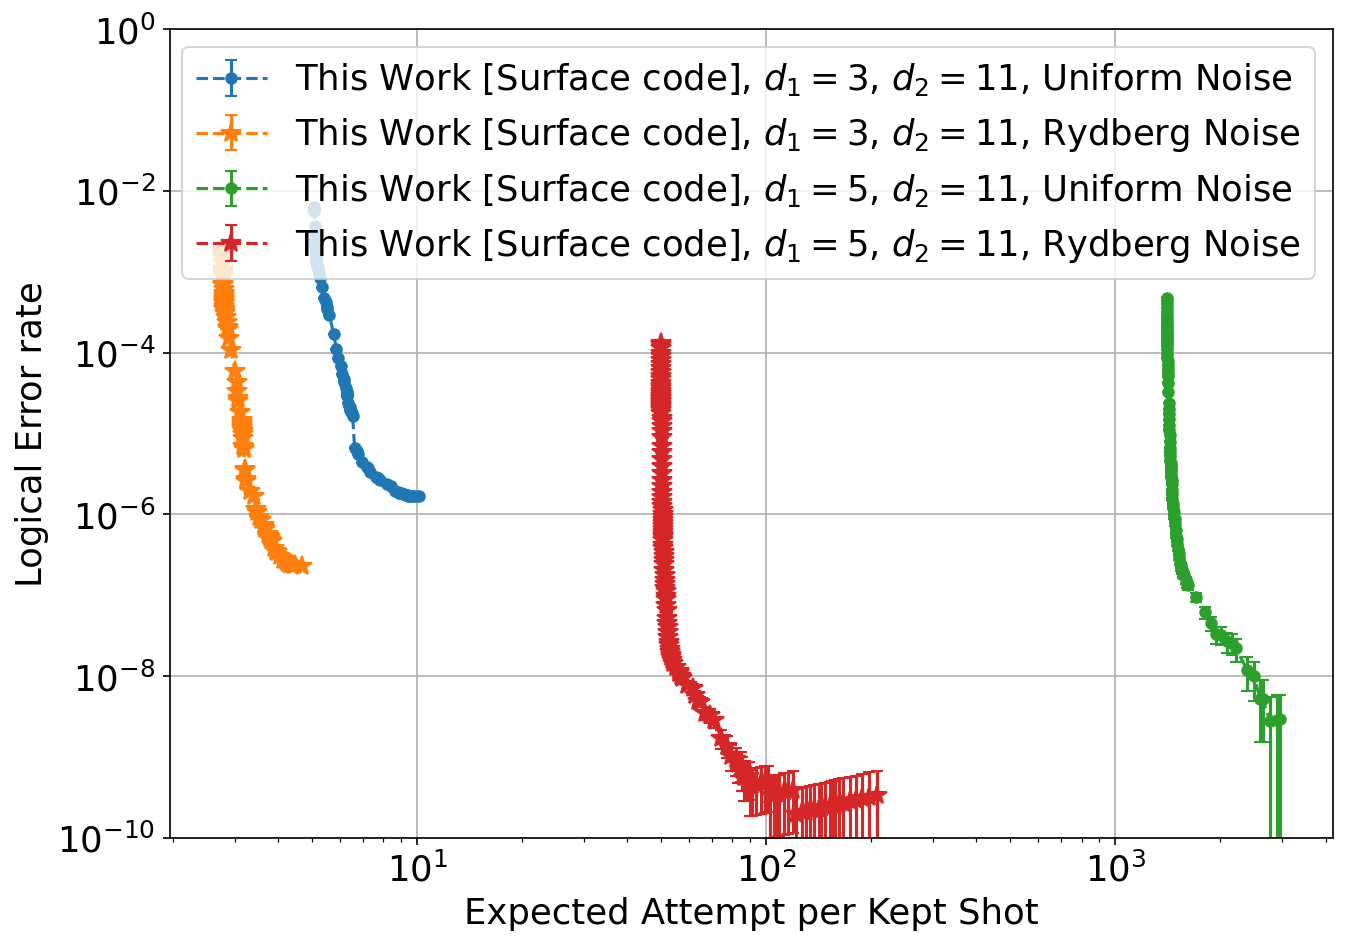

In [11]:
gap_samples = df[(df.decoder =='GapSampler') & (df.max_radius.isna()) & (df.p == 0.001)]

plt.figure(figsize=(10,7), dpi = 150)
steps = range(0, 150,    1)
for line in list(gap_samples.iloc):
    if line.d2 in [11] and line.d1 == line.num_ghz_measurements:
        xs, ys, yerr  = zip(*[get_step_from_line(line, step) for step in steps] )
        xs, ys, yerr = np.array(xs), np.array(ys), np.array(yerr)
        tick = '--.' if line['noise'] == 'uniform' else '--*'

        plt.errorbar(xs[ys>0], ys[ys>0], fmt=tick,yerr=yerr[ys>0] ,capsize = 3,label = get_name(line)+f", {noise_names[line['noise']]}",markersize = 10)
        
plt.yscale('log')
plt.xscale('log') 
plt.ylim(1e-10,1e0) 
plt.legend(fontsize = 17, loc = 'upper right')
plt.grid()
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.ylabel("Logical Error rate", fontsize = 17)
plt.xlabel("Expected Attempt per Kept Shot", fontsize=17)
# plt.title("Initialization and expansion (p=0.001)", fontsize = 17)
plt.savefig("figures/cultivation_and_expansion_atoms.png")

In [12]:
diagram_circuit = stim.Circuit("""QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(0, 1) 1
QUBIT_COORDS(-0.5, 0.5) 2
QUBIT_COORDS(0, 2) 3
QUBIT_COORDS(0.5, 1.5) 4
QUBIT_COORDS(0.5, 2.5) 5
QUBIT_COORDS(1, 0) 6
QUBIT_COORDS(1.5, -0.5) 7
QUBIT_COORDS(1, 1) 8
QUBIT_COORDS(0.5, 0.5) 9
QUBIT_COORDS(1, 2) 10
QUBIT_COORDS(1.5, 1.5) 11
QUBIT_COORDS(2, 0) 12
QUBIT_COORDS(2, 1) 13
QUBIT_COORDS(1.5, 0.5) 14
QUBIT_COORDS(2, 2) 15
QUBIT_COORDS(2.5, 1.5) 16
QUBIT_COORDS(4, 0) 17
QUBIT_COORDS(4, 1) 18
QUBIT_COORDS(3.5, 0.5) 19
QUBIT_COORDS(4, 2) 20
QUBIT_COORDS(4.5, 1.5) 21
QUBIT_COORDS(4.5, 2.5) 22
QUBIT_COORDS(5, 0) 23
QUBIT_COORDS(5.5, -0.5) 24
QUBIT_COORDS(5, 1) 25
QUBIT_COORDS(4.5, 0.5) 26
QUBIT_COORDS(5, 2) 27
QUBIT_COORDS(5.5, 1.5) 28
QUBIT_COORDS(6, 0) 29
QUBIT_COORDS(6, 1) 30
QUBIT_COORDS(5.5, 0.5) 31
QUBIT_COORDS(6, 2) 32
QUBIT_COORDS(6.5, 1.5) 33
QUBIT_COORDS(8, 0) 34
QUBIT_COORDS(8, 1) 35
QUBIT_COORDS(8, 2) 36
QUBIT_COORDS(9, 0) 37
QUBIT_COORDS(9, 1) 38
QUBIT_COORDS(9, 2) 39
QUBIT_COORDS(10, 0) 40
QUBIT_COORDS(10, 1) 41
QUBIT_COORDS(10, 2) 42
R 34 35 36 37 39 40 41 42
RX 38
TICK
CX 2 1 4 10 14 13 19 18 21 27 31 30 12 7 8 9 15 11 29 24 25 26 32 28 38 41
TICK
CX 2 0 4 8 14 12 19 17 21 25 31 29 6 7 1 9 10 11 23 24 18 26 27 28 38 35
TICK
CX 4 3 14 8 16 15 21 20 31 25 33 32 10 5 6 9 13 11 27 22 23 26 30 28 41 42 35 36 38 39
TICK
CX 4 1 14 6 16 13 21 18 31 23 33 30 3 5 0 9 8 11 20 22 17 26 25 28 41 40 35 34 38 37
TICK
MR 5 7 9 11 22 24 26 28
MRX 2 4 14 16 19 21 31 33
TICK
CX 34 0 35 1 36 3 37 6 38 8 39 10 40 12 41 13 42 15
TICK
CX 34 17 35 18 36 20 37 23 38 25 39 27 40 29 41 30 42 32
TICK
CX 2 1 4 10 14 13 19 18 21 27 31 30 12 7 8 9 15 11 29 24 25 26 32 28 41 40 35 34 38 37
TICK
CX 2 0 4 8 14 12 19 17 21 25 31 29 6 7 1 9 10 11 23 24 18 26 27 28 41 42 35 36 38 39
TICK
CX 4 3 14 8 16 15 21 20 31 25 33 32 10 5 6 9 13 11 27 22 23 26 30 28 38 35
TICK
CX 4 1 14 6 16 13 21 18 31 23 33 30 3 5 0 9 8 11 20 22 17 26 25 28 38 41
TICK
MR 5 7 9 11 22 24 26 28 34 35 36 37 39 40 41 42
MRX 2 4 14 16 19 21 31 33 38
TICK
""")

In [13]:
diagram = diagram_circuit.diagram("timeslice-svg", rows = 10)

In [14]:
with open("figures/timeslice.svg", "w") as timeslice:
    timeslice.write(diagram._repr_svg_())

In [ ]:
def get_file_name(json_metadata):
    c, d1, p, num_ghz_measurements, noise = json_metadata['c'], json_metadata['d1'], json_metadata['p'], json_metadata['num_ghz_measurements'], json_metadata['noise']
    filename = f'./circuits/c={c},d1={d1},p={p},num_ghz_measurements={num_ghz_measurements},noise={noise}.stim'
    return filename

def erasure_rate(line, p0, e):
    single_qubit_erasure_terms = 'DEPOLARIZE1','M','MR','MRX','MX','X_ERROR','Z_ERROR','Y_ERROR'
    two_qubit_erasure_terms = 'DEPOLARIZE2',
    other_erasure_terms = 'E',
    
    if line.name not in single_qubit_erasure_terms+two_qubit_erasure_terms+other_erasure_terms:
        return 1
    
    if line.name in single_qubit_erasure_terms:
        num_errors = len(line.targets_copy())
        args = line.gate_args_copy()
        if len(args):
            p = args[0]
        else:
            p = 0
        
    if line.name in two_qubit_erasure_terms:
        num_errors = len(line.targets_copy())//2
        p = line.gate_args_copy()[0]
        
    if line.name == 'E' and line.gate_args_copy()[0] != 0.25:
        p = line.gate_args_copy()[0]
        num_errors = 1
    elif line.name == 'E' and line.gate_args_copy()[0] == 0.25:
        p = 0
        num_errors = 0
        
    return (1-p/p0*e) ** num_errors
        
def erasure_probability(circuit, p0, e):
    no_erasure_probability = 1
    try:
        for line in circuit:
            no_erasure_probability *= erasure_rate(line, p0, e)
    except Exception as e:
        print(e, line)
        raise e
    return no_erasure_probability

In [16]:
es = 0, 2e-3, 4e-3

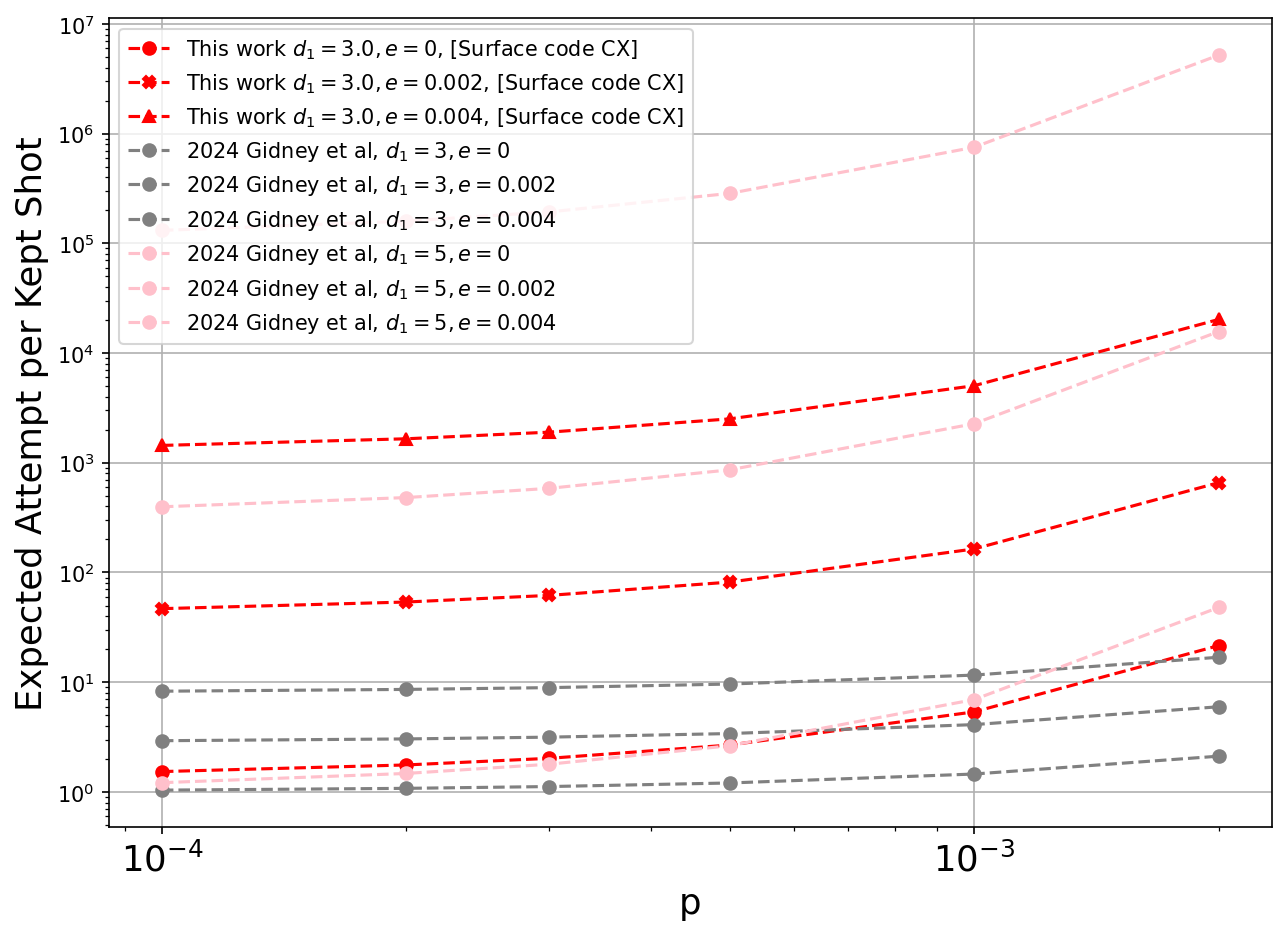

In [17]:
plt.figure(figsize=(10,7), dpi = 150)

for circuit in circuit_names.keys():
    for d1, dgroup  in df[ (df.circuit == circuit) & (df.noise == 'uniform')].groupby('d1'):
        for ghz_meas, group in dgroup.groupby('num_ghz_measurements'):
            if [d1, ghz_meas, circuit] in  [
                [3, 3, 'init'],
            ]:
                for marker,e in zip('oX^',es):
                    e_rates = []
                    for line in group.iloc:
                        json_metadata = loads(line['json_metadata'])
                        filename = get_file_name(json_metadata)
                        stim_circuit = stim.Circuit.from_file(filename)
                        p0 = json_metadata['p']
                        e_rates.append(erasure_probability(stim_circuit, p0, e))
                    x = 1/group.rate/np.array(e_rates)
                    y = np.array(group.error_rate)
                    x_filter = x < 1e3
                    plt.plot(ps[::-1], x,f'--{marker}',
                             label=f'This work $d_1={d1}, e={e}$, [{circuit_names[circuit]}]',
                            color = circuit_color[circuit])

d3_cultivation_circuit = stim.Circuit.from_file("./2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3.stim")
for e in es:
    erasure_rate_d3_cultivation = []
    for p in ps[::-1]:
        erasure_rate_d3_cultivation.append(erasure_probability(d3_cultivation_circuit, 0.001, e))
    plt.plot(ps[::-1], df3.rate/np.array(erasure_rate_d3_cultivation), '--o', 
    label=f'2024 Gidney et al, $d_1=3, e={e}$', color = 'gray')
    
d5_cultivation_circuit = stim.Circuit.from_file("./2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=42,b=Y,r=10,d1=5.stim")
for e in es:
    erasure_rate_d5_cultivation = []
    for p in ps[::-1]:
        erasure_rate_d5_cultivation.append(erasure_probability(d5_cultivation_circuit, 0.001, e))
    plt.plot(ps[::-1], df5.rate/np.array(erasure_rate_d5_cultivation), '--o', 
    label=f'2024 Gidney et al, $d_1=5, e={e}$', color = 'pink')

plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-15, 1)
# plt.ylim(1, 1e3)
# plt.xlim(1e-5,2e-3)
# plt.yticks(np.logspace(-15, 0, 16), fontsize = 17)
plt.xticks(fontsize = 17)
plt.legend(fontsize = 10)
plt.xlabel("p", fontsize = 17)
plt.ylabel("Expected Attempt per Kept Shot", fontsize=17)
# # plt.title("Initialization", fontsize = 17)
plt.grid()
plt.savefig("figures/erasure_init.png")

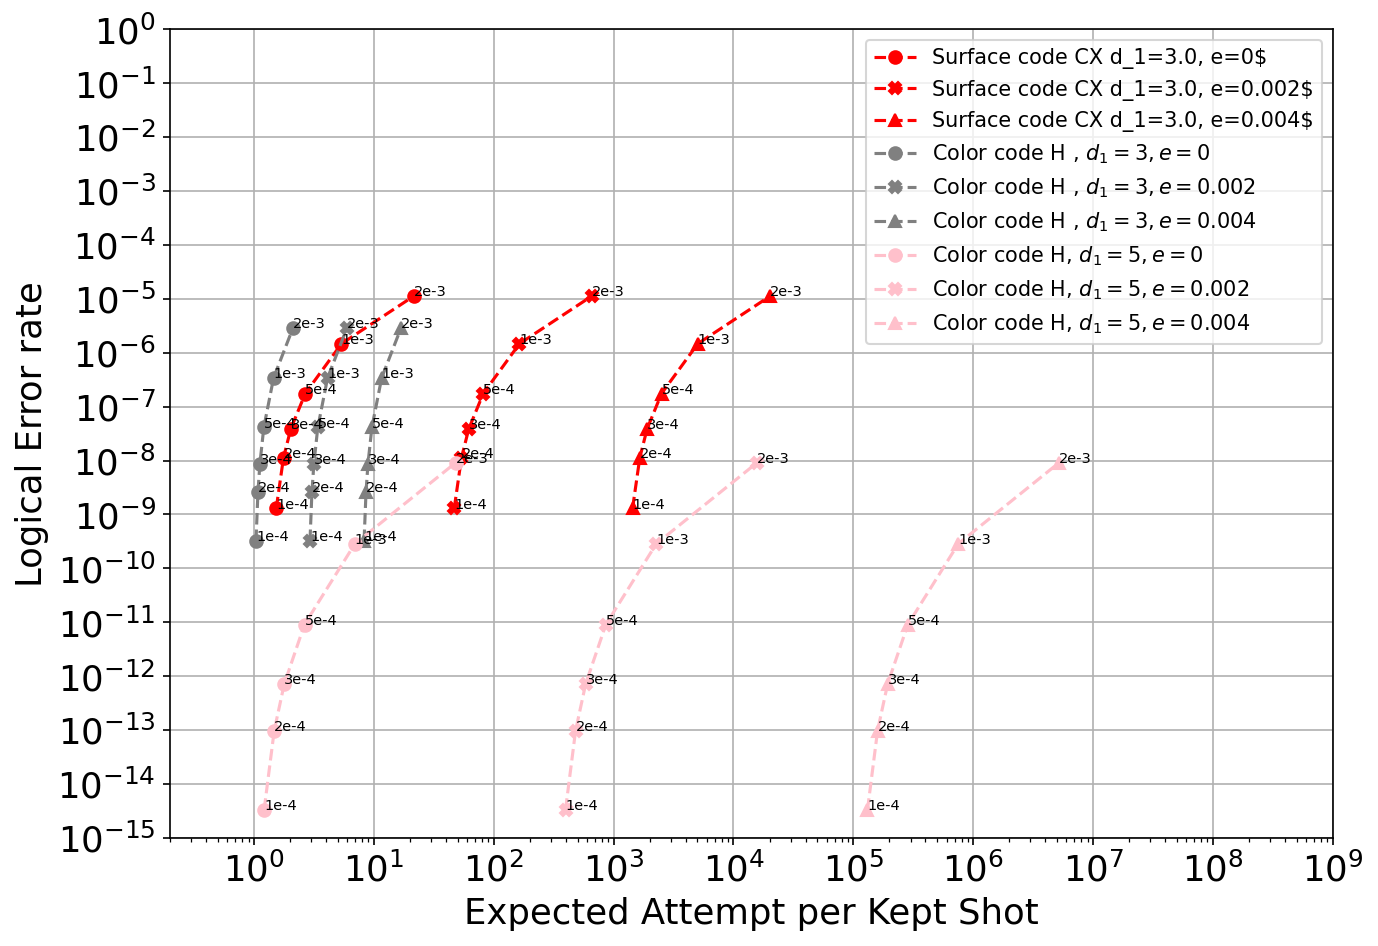

In [24]:
plt.figure(figsize=(10,7), dpi = 150)
markers = 'oX^<'
for circuit in circuit_names.keys():
    for d1, dgroup  in df[ (df.circuit == circuit) * (df.noise == 'uniform')].groupby('d1'):
        for ghz_meas, group in dgroup.groupby('num_ghz_measurements'):
            if [d1, ghz_meas, circuit] in  [
                [3, 3, 'init'],
            ]:
                for marker,e in zip(markers,es):
                    e_rates = []
                    for line in group.iloc:
                        json_metadata = loads(line['json_metadata'])
                        filename = get_file_name(json_metadata)
                        stim_circuit = stim.Circuit.from_file(filename)
                        p0 = json_metadata['p']
                        e_rates.append(erasure_probability(stim_circuit, p0, e))
                    x = 1/group.rate/np.array(e_rates)
                    y = np.array(group.error_rate)
                    x_filter = x < 1e3
                    plt.plot(x,y,f'--{marker}',
                             label=f'{circuit_names[circuit]} d_1={d1}, e={e}$',
                            color = circuit_color[circuit])
                    for p, p_label, rate, fid in zip(ps, p_labels[::-1], x, y):
                        if fid != 0: 
                            plt.text(rate, fid, p_label, fontsize = 7)


d3_cultivation_circuit = stim.Circuit.from_file("./2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3.stim")
for marker,e in zip(markers,es):
    erasure_rate_d3_cultivation = []
    for p in ps[::-1]:
        erasure_rate_d3_cultivation.append(erasure_probability(d3_cultivation_circuit, 0.001, e))
    plt.plot(df3.rate/np.array(erasure_rate_d3_cultivation), df3.PL,f'--{marker}', 
    label=f'Color code H , $d_1=3, e={e}$', color = 'gray')
    for p, p_label, rate, fid in zip(ps, p_labels[::-1], df3.rate/np.array(erasure_rate_d3_cultivation), df3.PL):
        plt.text(rate, fid, p_label, fontsize = 7)
    
d5_cultivation_circuit = stim.Circuit.from_file("./2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=42,b=Y,r=10,d1=5.stim")
for marker,e in zip(markers,es):
    erasure_rate_d5_cultivation = []
    for p in ps[::-1]:
        erasure_rate_d5_cultivation.append(erasure_probability(d5_cultivation_circuit, 0.001, e))
    plt.plot(df5.rate/np.array(erasure_rate_d5_cultivation), df5.PL, f'--{marker}', 
    label=f'Color code H, $d_1=5, e={e}$', color = 'pink')
    for p, p_label, rate, fid in zip(ps, p_labels[::-1], df5.rate/np.array(erasure_rate_d5_cultivation), df5.PL):
        plt.text(rate, fid, p_label, fontsize = 7)


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-15, 1)
plt.xlim(0.2,1e9)
plt.yticks(np.logspace(-15, 0, 16), fontsize = 17)
plt.xticks(fontsize = 17)
plt.legend(fontsize = 10, loc = 'upper right')
plt.ylabel("Logical Error rate", fontsize = 17)
plt.xlabel("Expected Attempt per Kept Shot", fontsize=17)
# # plt.title("Initialization", fontsize = 17)
plt.grid()
plt.savefig("figures/erasure_init_alternative.png")

In [19]:
df_e = df[df.decoder == 'SingleObservableGapSampler']

/tmp/ipykernel_509054/432332250.py:14: RuntimeWarning: invalid value encountered in divide
  fltr = (ys > 0) * (yerr/ys <  1)
/tmp/ipykernel_509054/432332250.py:8: RuntimeWarning: invalid value encountered in divide
  fltr = (ys > 0) * (yerr/ys <  1)
/tmp/ipykernel_509054/432332250.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-9, 0)


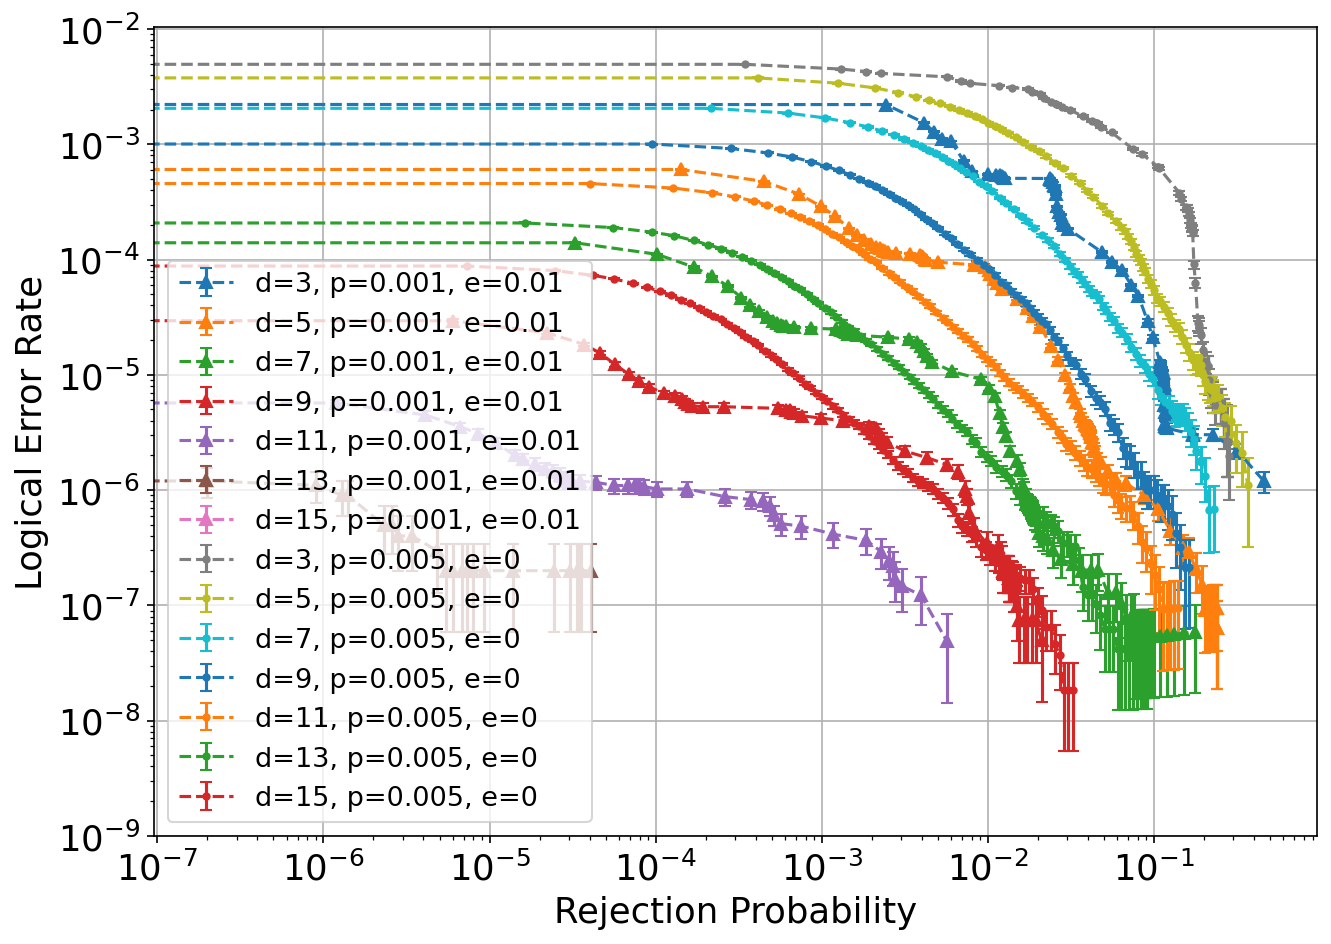

In [20]:
plt.figure(figsize=(10,7), dpi = 150)
steps = range(0, 250,    1)
for line in list(df_e.iloc):
    meta = loads(line.json_metadata)
    if meta['p'] == 5e-3 and 'e' not in meta:
        xs, ys, yerr  = zip(*[get_step_from_line(line, step) for step in steps] )
        xs, ys, yerr = np.array(xs), np.array(ys), np.array(yerr)
        fltr = (ys > 0) * (yerr/ys <  1)
        plt.errorbar(1-1/xs[fltr], ys[fltr],yerr=yerr[fltr],capsize = 3 ,fmt='--.', label = f"d={meta['d']}, p={meta['p']}, e=0")
#         plt.plot(xs[ys>0], ys[ys>0], '--.', label = f"d={meta['d']}, p={meta['p']}, e=0")
    if meta.get('e') == 1e-2 and meta['p'] == 1e-3  :
        xs, ys, yerr  = zip(*[get_step_from_line(line, step) for step in steps] )
        xs, ys, yerr = np.array(xs), np.array(ys), np.array(yerr)
        fltr = (ys > 0) * (yerr/ys <  1)

        plt.errorbar(1-1/xs[fltr], ys[fltr],yerr = yerr[fltr],capsize = 3, fmt= '--^', label = f"d={meta['d']}, p={meta['p']}, e={meta['e']}")
#         plt.plot(xs[ys>0], ys[ys>0], '--^', label = f"d={meta['d']}, p={meta['p']}, e={meta['e']}")
        
plt.yscale('log')
plt.xscale('log') 
plt.ylim(1e-9, 0)
plt.legend(fontsize = 13, loc = 'lower left')
plt.grid()
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.ylabel("Logical Error Rate", fontsize = 17)
plt.xlabel("Rejection Probability", fontsize=17)
# plt.title("Initialization and expansion (p=0.001)", fontsize = 17)
plt.savefig("figures/comp_gap_postselection.png")

/tmp/ipykernel_937957/1754056596.py:11: RuntimeWarning: divide by zero encountered in divide
  rej_probs = 1-1/xs


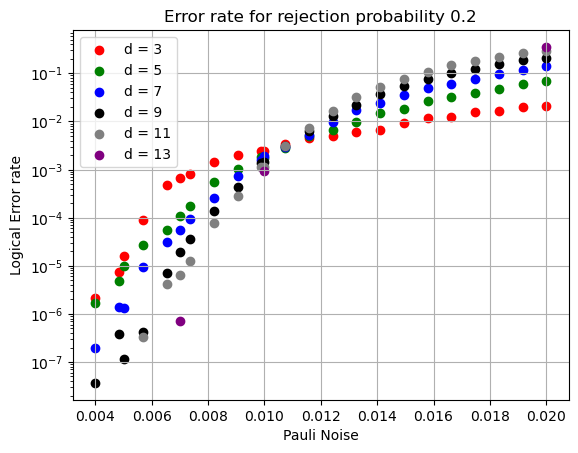

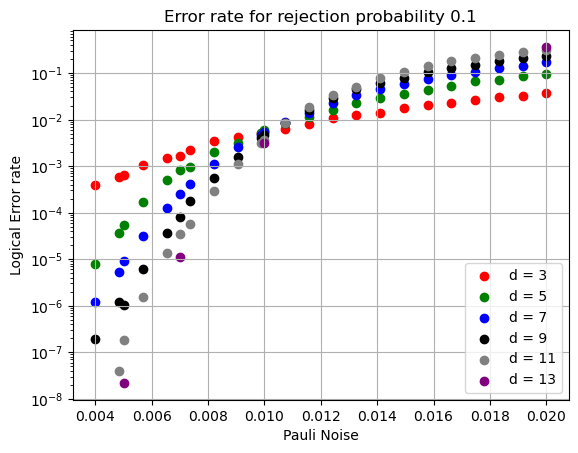

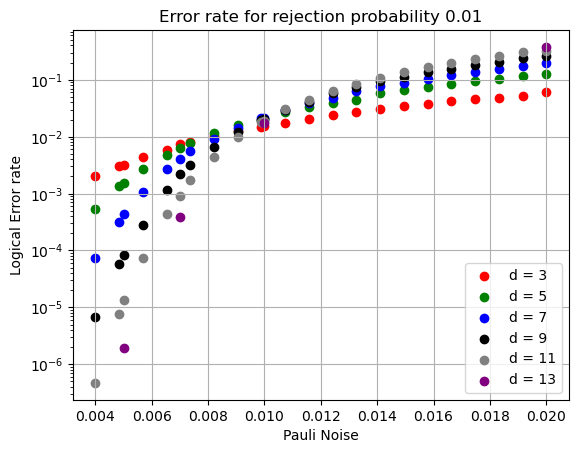

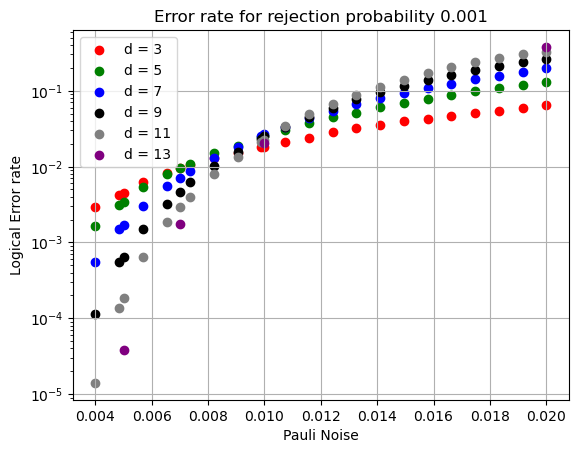

In [1212]:
colors = {3:"r",5:"g",7:"b",9:"black",11:"gray",13:'purple',15:'orange'}
for rejection_probability in [1/5, 1e-1, 1e-2, 1e-3]:
    plt.figure()
    for line in list(df_e.iloc):
        meta = loads(line.json_metadata)
        if meta['d'] in [15]:
            continue
        if 'e' not in meta:
            xs, ys  = zip(*[get_step_from_line(line, step) for step in steps] )
            xs, ys = np.array(xs), np.array(ys)
            rej_probs = 1-1/xs
            point_index = np.argmin((rej_probs - rejection_probability)**2)
            if ys[point_index] > 0:
                if meta['p'] == 2e-2:
                    plt.scatter(meta['p'], ys[point_index], color = colors[meta['d']], label = f"d = {meta['d']}")
                else:
                    plt.scatter(meta['p'], ys[point_index], color = colors[meta['d']])
    plt.yscale('log')
    plt.legend()
    plt.xlabel("Pauli Noise")
    plt.ylabel("Logical Error rate")
    plt.title(f"Error rate for rejection probability {rejection_probability}")
    plt.grid()

/tmp/ipykernel_937957/3022209765.py:15: RuntimeWarning: divide by zero encountered in divide
  rej_probs = 1-1/xs


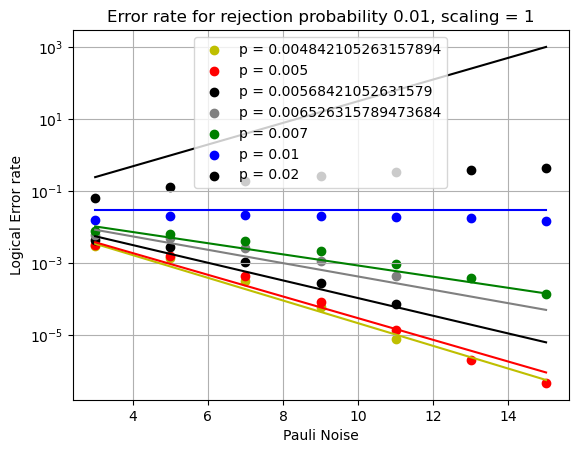

In [1165]:
colors = dict(zip([0.005,0.007,0.01,0.02,0.006526315789473684,0.004842105263157894,0.00568421052631579],
                  ("r","g","b","black","gray",'y','k')))
ds = np.array([3,5,7,9,11,13,15])
scaling = 1
for rejection_probability in [1e-2]:
    plt.figure()
    for line in list(df_e.iloc):
        meta = loads(line.json_metadata)
        if meta['p'] not in colors:
#             print(meta['p'])
            continue
        if 'e' not in meta:
            xs, ys  = zip(*[get_step_from_line(line, step) for step in steps] )
            xs, ys = np.array(xs), np.array(ys)
            rej_probs = 1-1/xs
            point_index = np.argmin((rej_probs - rejection_probability)**2)
            if ys[point_index] > 0:
                if meta['d'] == 5:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']], label = f"p = {meta['p']}")
                    plt.plot(ds, 0.03*(meta['p']/0.01) ** (ds*scaling),color = colors[meta['p']])
                else:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']])
    plt.yscale('log')
    plt.legend()
    plt.xlabel("Pauli Noise")
    plt.ylabel("Logical Error rate")
    plt.title(f"Error rate for rejection probability {rejection_probability}, scaling = {scaling}")
    plt.grid()

/tmp/ipykernel_937957/1888168973.py:16: RuntimeWarning: divide by zero encountered in divide
  rej_probs = 1-1/xs


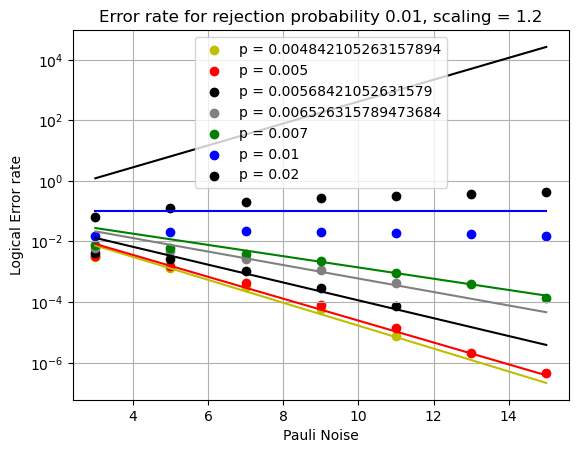

In [1157]:
colors = dict(zip([0.005,0.007,0.01,0.02,0.006526315789473684,0.004842105263157894,0.00568421052631579],
                  ("r","g","b","black","gray",'y','k')))
ds = np.array([3,5,7,9,11,13,15])
scaling = 1.2
for rejection_probability in [1e-2]:
    plt.figure()
    for line in list(df_e.iloc):
        meta = loads(line.json_metadata)
        if 'e' not in meta:
            if meta['p'] not in colors:
#                 print(meta['p'])
                continue
            
            xs, ys  = zip(*[get_step_from_line(line, step) for step in steps] )
            xs, ys = np.array(xs), np.array(ys)
            rej_probs = 1-1/xs
            point_index = np.argmin((rej_probs - rejection_probability)**2)
            if ys[point_index] > 0:
                if meta['d'] == 5:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']], label = f"p = {meta['p']}")
                    plt.plot(ds, 0.1*(meta['p']/0.01) ** (ds*scaling),color = colors[meta['p']])
                else:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']])
    plt.yscale('log')
    plt.legend()
    plt.xlabel("Pauli Noise")
    plt.ylabel("Logical Error rate")
    plt.title(f"Error rate for rejection probability {rejection_probability}, scaling = {scaling}")
    plt.grid()

/tmp/ipykernel_937957/3328387546.py:16: RuntimeWarning: divide by zero encountered in divide
  rej_probs = 1-1/xs


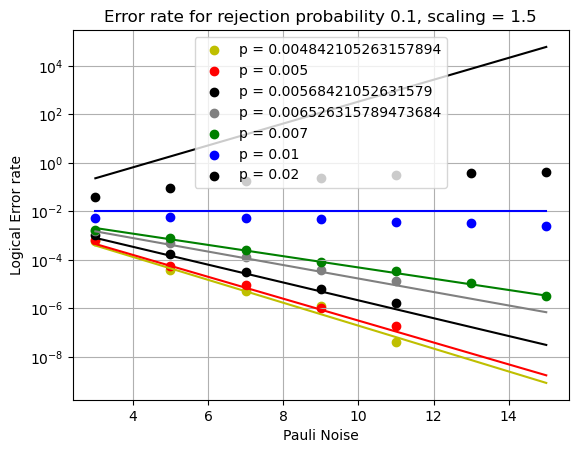

In [1158]:
colors = dict(zip([0.005,0.007,0.01,0.02,0.006526315789473684,0.004842105263157894,0.00568421052631579],
                  ("r","g","b","black","gray",'y','k')))
ds = np.array([3,5,7,9,11,13,15])
scaling = 1.5
for rejection_probability in [1e-1]:
    plt.figure()
    for line in list(df_e.iloc):
        meta = loads(line.json_metadata)
        if 'e' not in meta:
            if meta['p'] not in colors:
#                 print(meta['p'])
                continue
            
            xs, ys  = zip(*[get_step_from_line(line, step) for step in steps] )
            xs, ys = np.array(xs), np.array(ys)
            rej_probs = 1-1/xs
            point_index = np.argmin((rej_probs - rejection_probability)**2)
            if ys[point_index] > 0:
                if meta['d'] == 5:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']], label = f"p = {meta['p']}")
                    plt.plot(ds, 0.01*(meta['p']/0.01) ** (ds*scaling),color = colors[meta['p']])
                else:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']])
    plt.yscale('log')
    plt.legend()
    plt.xlabel("Pauli Noise")
    plt.ylabel("Logical Error rate")
    plt.title(f"Error rate for rejection probability {rejection_probability}, scaling = {scaling}")
    plt.grid()

/tmp/ipykernel_937957/1921414168.py:16: RuntimeWarning: divide by zero encountered in divide
  rej_probs = 1-1/xs


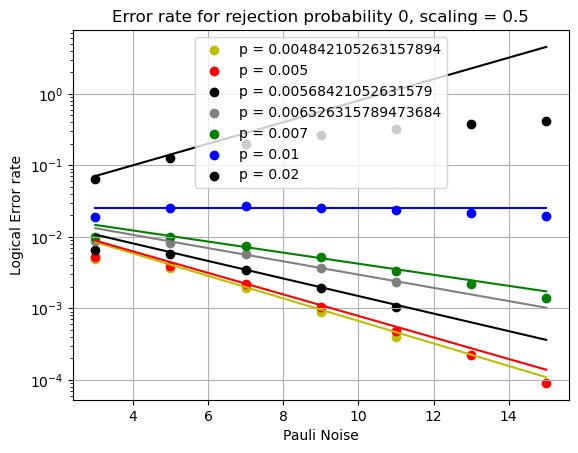

In [1161]:
colors = dict(zip([0.005,0.007,0.01,0.02,0.006526315789473684,0.004842105263157894,0.00568421052631579],
                  ("r","g","b","black","gray",'y','k')))
ds = np.array([3,5,7,9,11,13,15])
scaling = 0.5
for rejection_probability in [0]:
    plt.figure()
    for line in list(df_e.iloc):
        meta = loads(line.json_metadata)
        if 'e' not in meta:
            if meta['p'] not in colors:
#                 print(meta['p'])
                continue
            
            xs, ys  = zip(*[get_step_from_line(line, step) for step in steps] )
            xs, ys = np.array(xs), np.array(ys)
            rej_probs = 1-1/xs
            point_index = np.argmin((rej_probs - rejection_probability)**2)
            if ys[point_index] > 0:
                if meta['d'] == 5:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']], label = f"p = {meta['p']}")
                    plt.plot(ds, 0.025*(meta['p']/0.01) ** (ds*scaling),color = colors[meta['p']])
                else:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']])
    plt.yscale('log')
    plt.legend()
    plt.xlabel("Pauli Noise")
    plt.ylabel("Logical Error rate")
    plt.title(f"Error rate for rejection probability {rejection_probability}, scaling = {scaling}")
    plt.grid()

/tmp/ipykernel_937957/2671214445.py:16: RuntimeWarning: divide by zero encountered in divide
  rej_probs = 1-1/xs


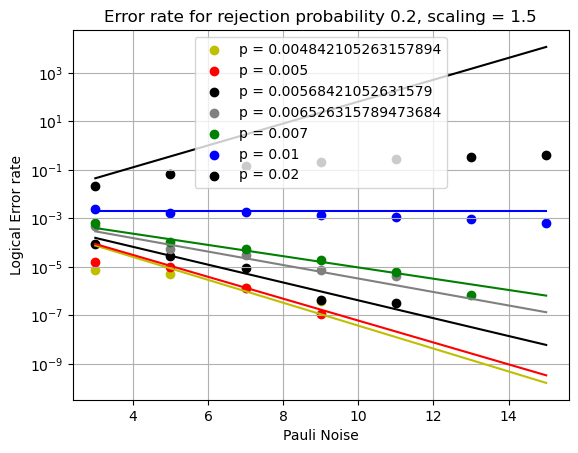

In [1168]:
colors = dict(zip([0.005,0.007,0.01,0.02,0.006526315789473684,0.004842105263157894,0.00568421052631579],
                  ("r","g","b","black","gray",'y','k')))
ds = np.array([3,5,7,9,11,13,15])
scaling = 1.5
for rejection_probability in [2e-1]:
    plt.figure()
    for line in list(df_e.iloc):
        meta = loads(line.json_metadata)
        if 'e' not in meta:
            if meta['p'] not in colors:
#                 print(meta['p'])
                continue
            
            xs, ys  = zip(*[get_step_from_line(line, step) for step in steps] )
            xs, ys = np.array(xs), np.array(ys)
            rej_probs = 1-1/xs
            point_index = np.argmin((rej_probs - rejection_probability)**2)
            if ys[point_index] > 0:
                if meta['d'] == 5:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']], label = f"p = {meta['p']}")
                    plt.plot(ds, 0.002*(meta['p']/0.01) ** (ds*scaling),color = colors[meta['p']])
                else:
                    plt.scatter(meta['d'], ys[point_index], color = colors[meta['p']])
    plt.yscale('log')
    plt.legend()
    plt.xlabel("Pauli Noise")
    plt.ylabel("Logical Error rate")
    plt.title(f"Error rate for rejection probability {rejection_probability}, scaling = {scaling}")
    plt.grid()